In [4]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import math
import numpy as np
%matplotlib inline

## Train the model

In [ ]:
model = YOLO('yolov8n-pose.pt')
model.train(data='thermal-dataset.yaml', epochs=1, save=True)

New https://pypi.org/project/ultralytics/8.0.132 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.112 🚀 Python-3.11.3 torch-2.0.1 CPU
yolo/engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=thermal-dataset.yaml, epochs=1, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, f

In [2]:
model_yolov8_pose = YOLO('yolov8n-pose.pt')
model_ft_thermal = YOLO('runs/pose/train/weights/best.pt') # Change this according with previous output

## Evaluate

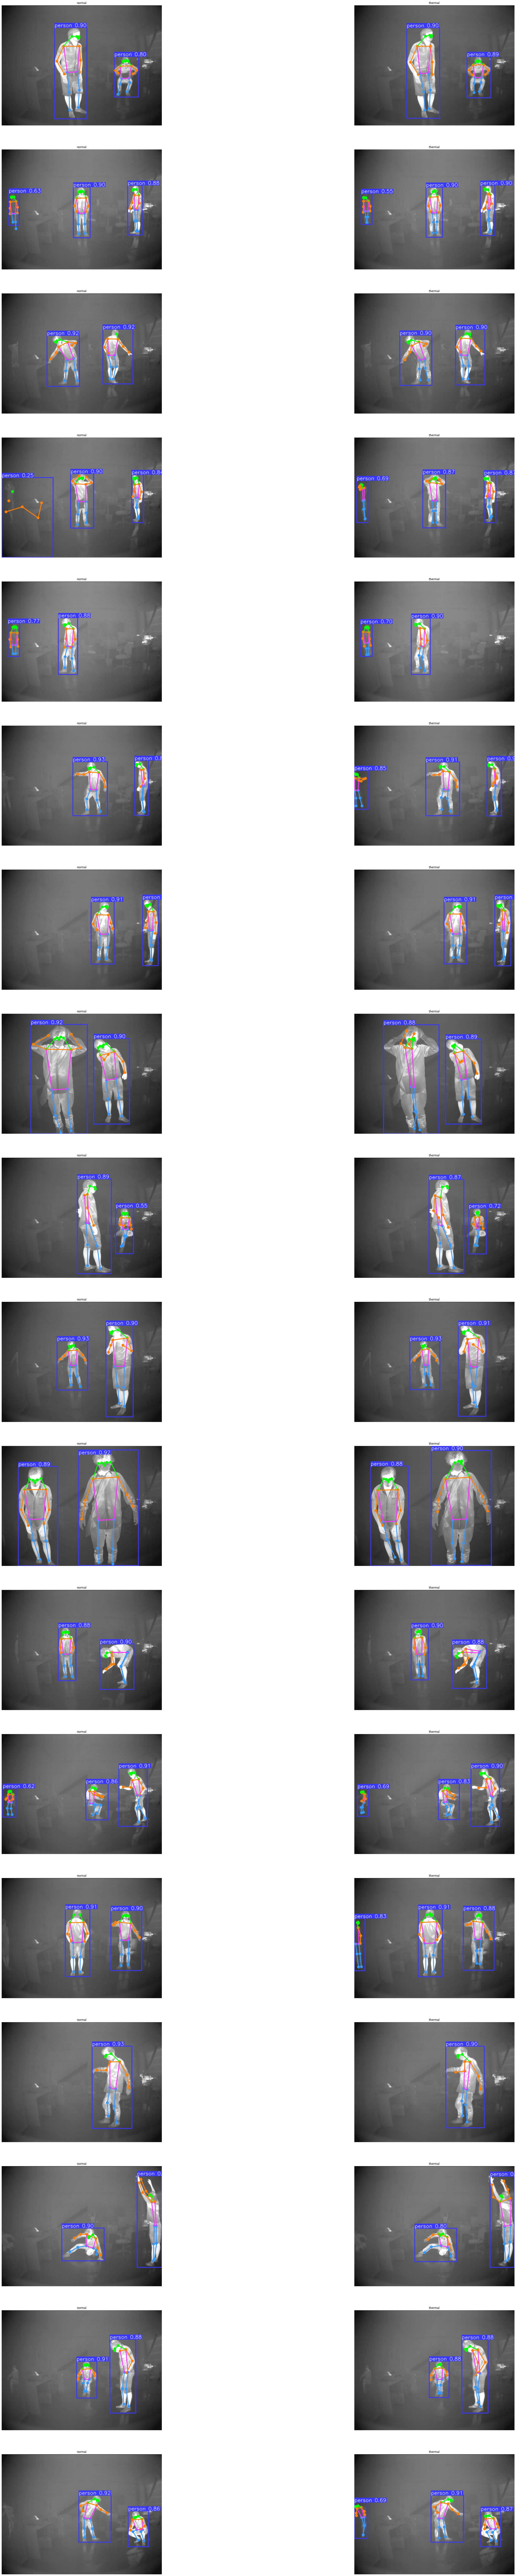

In [5]:
test_images= 18
fig, axes = plt.subplots(nrows=test_images, ncols=2, figsize=(50,200))


for i, image in enumerate(os.listdir('test')[:test_images]):

    results_yolov8_pose = model_yolov8_pose('test/' + image, verbose=False)
    results_ft_thermal = model_ft_thermal('test/' + image, verbose=False)
    
    axes[i, 0].imshow(results_yolov8_pose[0].plot())
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title('normal')

    axes[i, 1].imshow(results_ft_thermal[0].plot())
    axes[i, 1].set_axis_off()
    axes[i, 1].set_title('thermal')



In [10]:
def aspect_ratio(box):
    x1, y1, x2, y2, _, _ = box
    return (x2 - x1) / (y2 - y1)

def draw_annotations(object_detection, image):
    for i, box in enumerate(object_detection[0].boxes.data):
        if aspect_ratio(box) > 1:
            shapes = np.zeros_like(image, np.uint8)
            cv2.rectangle(shapes, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), cv2.FILLED)
            out = image.copy()
            alpha = 0.5
            mask = shapes.astype(bool)
            out[mask] = cv2.addWeighted(image, alpha, shapes, 1 - alpha, 0)[mask]
            image = out

            x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
            cv2.putText(image,'Fall', (int( x1 + (x2-x1)/2), int( y1 + (y2-y1)/2 ) ), cv2.FONT_HERSHEY_SIMPLEX,  1, (255,255,255), 3, 2)
    
    return image

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def process_video(file_path, out_file_path):
    video = cv2.VideoCapture(file_path)

    if not video.isOpened():
        raise ValueError("Could not open video file")

    # Get video properties
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = video.get(cv2.CAP_PROP_FPS)
    frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Calculate the center of the frame
    center_x = frame_width // 2
    center_y = frame_height // 2
    
    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_file_path, fourcc, frame_rate, (frame_width, frame_height))
    
    # Iterate over each frame in the video
    while video.isOpened():
        # Read the next frame
        ret, frame = video.read()
        
        # If the frame was read successfully, draw the square and write it to the output video
        if ret:
            
            im = Image.fromarray(frame)
            im.save("temp.png")
            results_ft_thermal= model_yolov8_pose('temp.png', verbose=False)

            frame = draw_annotations(results_ft_thermal, results_ft_thermal[0].plot())
            
            
            # Write the frame to the output video
            out.write(frame)
        else:
            # If the frame was not read successfully, we've reached the end of the video
            break
    
    # Release the VideoCapture and VideoWriter objects
    video.release()
    out.release()


#process_video('falls-sample.mp4', 'falls-output.mp4')
process_video('thermal-sample.mp4', 'thermal-output.mp4')

